# Notes too self:
I have got to put more of yhis in functions cause this is so busy!
20
I want to run this again on the wonderful 20-60 first images found in the other dataset! I think that will give a much prettier image 

In [15]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
from PIL import Image
import cv2
from matplotlib.colors import LogNorm
import pandas as pd
import imutils
from cellpose import utils, io
from scipy.spatial import distance as dist
from imutils import perspective
import re
import tools
from radfil import radfil_class, styles
from astropy import units as u
import imageio
import skimage.morphology as sk_m
from fil_finder import FilFinder2D

segments_path = "/home/keeganfl/Desktop/Math_612_project/05-10-2015/cellpose_height/"

# Step 1
Loading up a list of segmentation (.npy) files to be run through the process. These files are then sorted by timepoint.

In [16]:
# Load files
files = os.listdir(segments_path)
for fichier in files[:]: 
    if not(fichier.endswith(".npy")):
        files.remove(fichier)

# Sort files by timepoint
files.sort(key = tools.natural_keys)

# Step 2
Load up the data and specifically save the full image and outlines for each cell. 

In [24]:
# Initialize lists
outl_list = []
img_list = []

# Fill lists with img and outline data from each file
for file in files[8:]:
    dat = np.load(segments_path + file, allow_pickle=True).item()
    # Create a list that contains each outline.
    outl = tools.outlines_list(dat['masks'])
    outl_list.append(outl)
    # Create a list that contains each image file. 
    image = dat["img"]
    img_list.append(image)

# Step 3
Create bounding boxes for each outline in each image. 

In [25]:
boxes_list = []
for outl in outl_list:
    boxes = tools.get_boxes(outl)
    boxes_list.append(boxes)

# Step 4
Perform cell tracking and save the ID, outline, and centers through time as lists. The reason we are saving the outlines as a list again is because these outlines will be aligned with the ID list, so we will always know which outline belongs to which specific cell over time.

In [26]:
# initialize our centroid tracker and frame dimensions
ct = tools.CentroidTracker()
(H, W) = (None, None)

# Initialize a new set of lists that will contain lists of IDs, outlines, and centers for each image file. 
IDs_list = []
outl_new_list = []
centers_list = []
box_img = img_list.copy()


# loop over the outlines and boxes for each file.
for boxes, img, outls in zip(boxes_list, box_img, outl_list):
    # Draw an outline of each box onto the original image
    for box in boxes:
        (startX, startY, endX, endY) = box.astype("int")
    # update our centroid tracker using the computed set of bounding box rectangles
    objects = ct.update(boxes, outls)
    # Initialize a new set of lists
    IDs = []
    outl_new = []
    centers = []
    # loop over the tracked objects
    for (objectID, info) in objects.items():
        # draw both the ID of the object and the centroid of the
        # object on the output frame
        text = "ID {}".format(objectID)
        # append the object ID and its associated outline and center to the lists. 
        IDs.append(objectID)
        outl_new.append(info[1])
        centers.append(info[0])
    IDs_list.append(IDs)
    outl_new_list.append(outl_new)
    centers_list.append(centers)

# Step 5
Determining the number of pixels which overlap between the different outlines

In [51]:
def get_overlap(outl, boxes):
    cell_overlaps = []
    for out_cell, box_cell in zip(outl, boxes):
        adj = 0
        for out_oth, box_oth in zip(outl, boxes):
            p1 = Polygon(box_cell)
            p2 = Polygon(box_oth)
            # centroid distance cuttod=ff = 150 pixels. 
            if p1.intersects(p2) == False or p1 == p2:
                continue
            for pixel1 in out_cell:
                for pixel2 in out_oth:
                    distx = np.abs(pixel1[0]-pixel2[0])
                    disty = np.abs(pixel1[1]-pixel2[1])
                    if distx + disty == 1:
                        adj = adj + 1
        cell_overlaps.append(adj)
    return cell_overlaps 

In [54]:
# about 20 seconds, twice as fast!!! Will probably have even greater gains with higher cell density. 
overl_list = []
for outl, boxes in zip(outl_list, boxes_list):
    overl_list.append(get_overlap(outl, boxes))

In [53]:
overl_list[0]

[71,
 52,
 40,
 40,
 16,
 16,
 61,
 159,
 110,
 140,
 159,
 100,
 19,
 26,
 72,
 98,
 72,
 59,
 59,
 35]

In [49]:
p1 = Polygon(boxes_list[0][0])
p2 = Polygon(boxes_list[0][0])
p1.intersects(p2)

True

In [50]:
p1 == p2

True

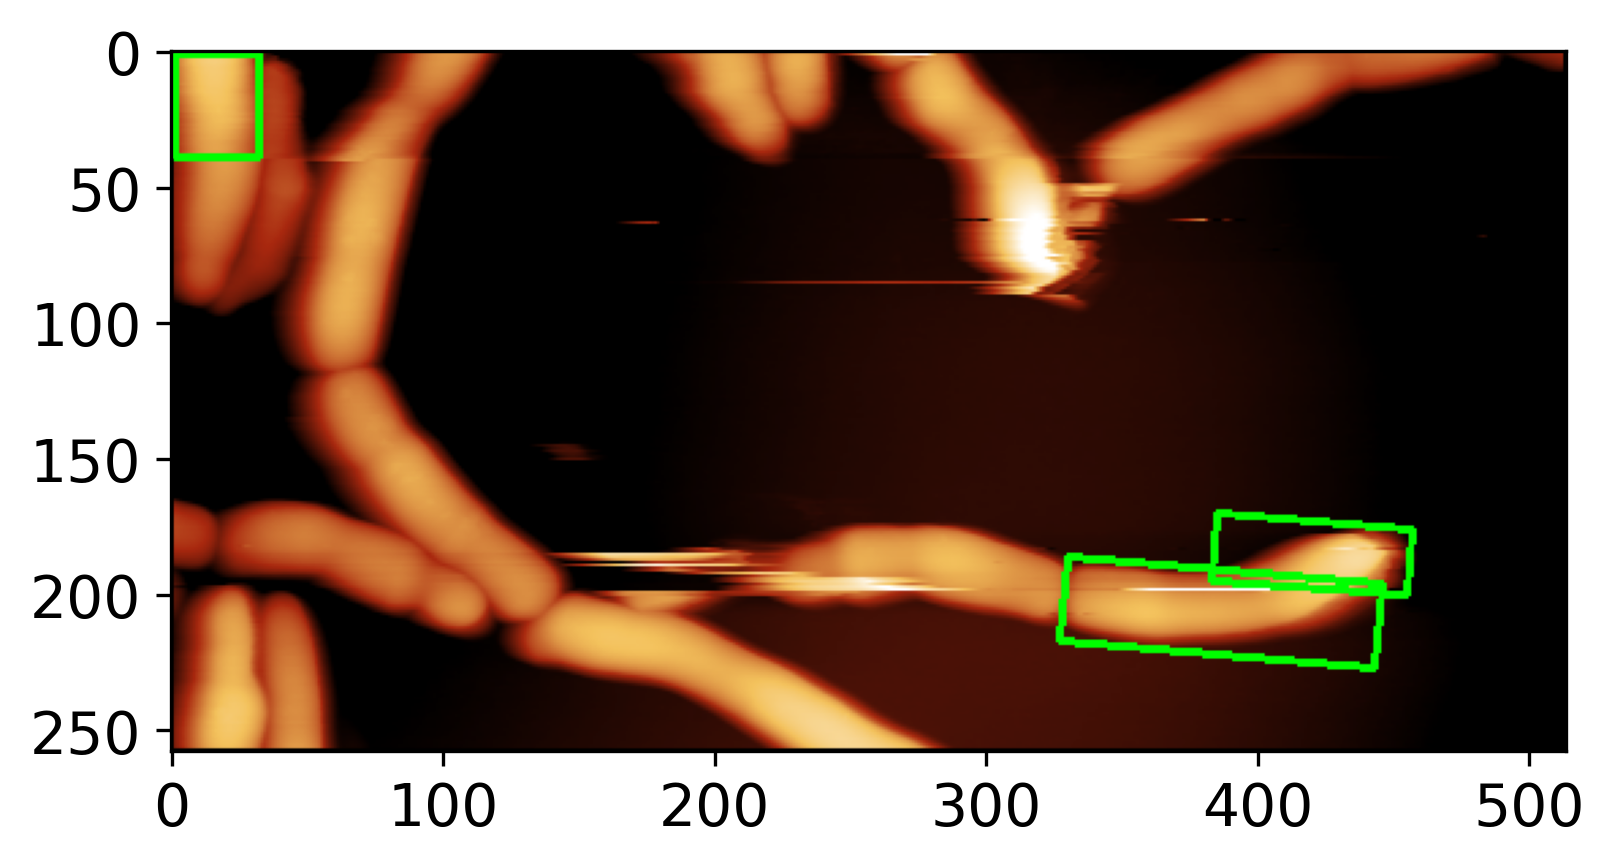

In [32]:
cv2.drawContours(img_list[0], [boxes_list[0][14].astype("int")], -1, (0, 255, 0), 2)
plt.imshow(img_list[0])

In [13]:
from shapely.geometry import Polygon
p1 = Polygon([(10,15), (10,16), (11,16), (11,15)])
p2 = Polygon([(0,1), (1,0), (1,1), (0,1)])
print(p1.intersects(p2))

False


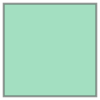

In [14]:
p1